In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import timm
import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
import timm
import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall
from sklearn.metrics import precision_score, recall_score
import numpy as np
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


/home/papameil/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/papameil/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Data Prpcessing of Single Cell Spectra

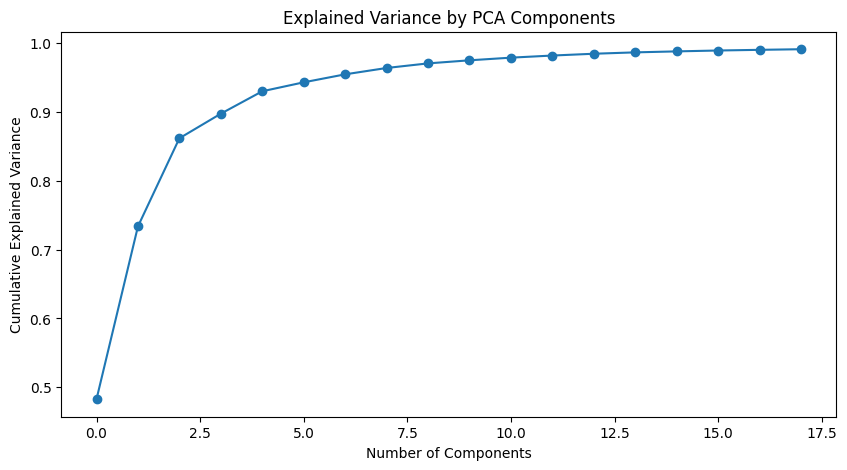

Number of components selected: 18


In [3]:
# dataset
data = pd.read_csv('/mnt/projects/papameil/Salmonella_PCA/combined_salmonella_data.csv')

# Reshape data 
data['ImageID'] = (data['InImage_ID'] == 1).cumsum()  # Creates a new image ID per reset
aggregated_data = data.groupby(['ImageID', 'Serovar']).mean().reset_index()

# Separate features and labels
X = aggregated_data.iloc[:, 2:304]  # Assuming bands are in columns 2-304
y = aggregated_data['Serovar']

class_labels = y.unique()

# get rid of nan values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

# y labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 
pca = PCA(n_components=0.99)  # Keep 99% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

# result
print("Number of components selected:", X_train_pca.shape[1])

## Define MLP Model

In [4]:
class MLPClassifierTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPClassifierTorch, self).__init__()
        self.linear_layer_1 = nn.Linear(in_features=input_size, out_features=100)  # Hidden layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(in_features=100, out_features=output_size)  # Output layer

    def forward(self, x):
        x = self.linear_layer_1(x)
        x = self.relu(x)
        out = self.output_layer(x)
        return out

## Import EfficientNetV2 and Create SpectralSpatial Fusion

In [5]:
# Define the model class
class EfficientNet(pl.LightningModule):
    
    def __init__(self, output_len=5):
        super(EfficientNet, self).__init__()
        
        # create an instance of the EfficientNet model
        self.model = timm.create_model('efficientnetv2_rw_s', num_classes = output_len, pretrained=True)
        
        # Define metrics for each stage
        self.train_acc = Accuracy(task='multiclass', num_classes=5)
        self.train_precision = Precision(task='multiclass', num_classes=5)
        self.train_recall = Recall(task='multiclass', num_classes=5)
        #self.train_f1 = F1(task='multiclass', num_classes=5)
        
        self.val_acc = Accuracy(task='multiclass', num_classes=5)
        self.val_precision = Precision(task='multiclass', num_classes=5)
        self.val_recall = Recall(task='multiclass', num_classes=5)
        #self.val_f1 = F1(task='multiclass', num_classes=5)
        
        self.test_acc = Accuracy(task='multiclass', num_classes=5)
        self.test_precision = Precision(task='multiclass', num_classes=5)
        self.test_recall = Recall(task='multiclass', num_classes=5)
        #self.test_f1 = F1(task='multiclass', num_classes=5)
    # forward pass function
    def forward(self,x):
        out = self.model(x) # pass the input through the model
        return out
    # training step function
    def training_step(self, batch, batch_idx):
        input = batch[0][0]
        target = batch[1]
        pred = self.model(input)
        loss = F.cross_entropy(pred.float(), target)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        # Update metrics
        self.train_acc(pred, target)
        self.train_precision(pred, target)
        self.train_recall(pred, target)
        self.train_f1(pred, target)

        
        return loss

    # validation step function
    def validation_step(self, batch, batch_idx):
        input = batch[0][0]
        target = batch[1]
        pred = self.model(input)
        # compute the loss using cross entropy loss function
        loss = F.cross_entropy(pred.float(), target)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Update metrics
        self.val_acc(pred, target)
        self.val_precision(pred, target)
        self.val_recall(pred, target)
        self.val_f1(pred, target)

        return loss
        
    # testing step function
    def test_step(self, batch, batch_idx):
        input = batch[0][0]
        target = batch[1]
        pred = self.model(input)
        # compute the loss using cross entropy loss function
        loss = F.cross_entropy(pred.float(), target)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        # Update metrics
        self.test_acc(pred, target)
        self.test_precision(pred, target)
        self.test_recall(pred, target)
        self.test_f1(pred, target)
        return loss

    def on_train_epoch_end(self):
        # log epoch metric
        self.log('train_acc_epoch', self.train_acc.compute(), sync_dist=True)
        self.log('train_precision_epoch', self.train_precision.compute(), sync_dist=True)
        self.log('train_recall_epoch', self.train_recall.compute(), sync_dist=True)
        self.log('train_f1_epoch', self.train_f1.compute(), sync_dist=True)

        # reset metrics
        self.train_acc.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()

    def on_validation_epoch_end(self):
        # log epoch metric
        self.log('val_acc_epoch', self.val_acc.compute(), sync_dist=True)
        self.log('val_precision_epoch', self.val_precision.compute(), sync_dist=True)
        self.log('val_recall_epoch', self.val_recall.compute(), sync_dist=True)
        self.log('val_f1_epoch', self.val_f1.compute(), sync_dist=True)

        # reset metrics
        self.val_acc.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()

    def on_test_epoch_end(self):
        # log epoch metric
        self.log('test_acc_epoch', self.test_acc.compute(), sync_dist=True)
        self.log('test_precision_epoch', self.test_precision.compute(), sync_dist=True)
        self.log('test_recall_epoch', self.test_recall.compute(), sync_dist=True)
        self.log('test_f1_epoch', self.test_f1.compute(), sync_dist=True)

        # reset metrics
        self.test_acc.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()


    # define the optimizer and learning rate scheduler
    def configure_optimizers(self):
        # create an instance of the AdamW optimizer
        opt = torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-2) # default: lr=1e-3
        # sch = lr_scheduler.StepLR(opt, step_size=10, gamma=0.3) # every epoch by default
        # return ({'optimizer': opt, 'lr_scheduler':sch})
        
        # create a learning rate scheduler that decreases the learning rate every 10 epochs by a factor of 0.3
        sch = {'scheduler': lr_scheduler.StepLR(opt, step_size=10, gamma=0.3)}
        return [opt], [sch]
    
class SpectralSpatialNet(nn.Module):
    def __init__(self, mlp_model, efficientnet_model, num_classes):
        super(SpectralSpatialNet, self).__init__()
        self.mlp_model = mlp_model
        self.efficientnet_model = efficientnet_model
        self.efficientnet_model.model.classifier = nn.Identity()  # Remove the classifier layer
        
        # Projection layers to ensure matching feature dimensions
        #self.spectral_projection_layer = nn.Linear(mlp_model.output_layer.out_features, 32)
        #self.spatial_projection_layer = nn.Linear(efficientnet_model.model.num_features, 32)
        
        #self.fusion_layer = nn.Linear(64, 128)  # Adjusted input size
        #self.classifier = nn.Linear(128, num_classes)
    
    def forward(self, spectral_data, image_data):
        spectral_features = self.mlp_model(spectral_data)
        spatial_features = self.efficientnet_model(image_data)
        print(spectral_features.shape)
        print(spatial_features.shape)
        # Project features to the same size
        spectral_features = self.spectral_projection_layer(spectral_features)
        spatial_features = self.spatial_projection_layer(spatial_features)
        
        combined_features = torch.cat((spectral_features, spatial_features), dim=1)
        fused_features = self.fusion_layer(combined_features)
        output = self.classifier(fused_features)
        return output
class SpectralSpatialNet(EfficientNet):
    # initialization function
    def __init__(self, num_classes=5, output_len: int=None):
        if output_len is None:
            super(SpectralSpatialNet, self).__init__(num_classes)
            output_len = num_classes
        else:
            super(SpectralSpatialNet, self).__init__(output_len)

        self.spectral_feature_extractor = nn.Sequential(
            nn.Linear(303, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, output_len),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2*output_len, 2*output_len),
            nn.ReLU(),
            nn.Linear(2*output_len, 5),
        )
        self.img_ln = nn.LayerNorm(output_len)
        self.spectral_ln = nn.LayerNorm(output_len)

        self.img_bn = nn.BatchNorm1d(output_len)
        self.spectral_bn = nn.BatchNorm1d(output_len)

    # forward pass function
    def forward(self,x):
        img, mask, spectra = x

        # efficient_net extraction
        img_features = self.model(img)
        # return img_features
        # spectral extraction
        spectral_features = self.spectral_feature_extractor(spectra)

        # normalize features from each branch
        img_features = self.img_bn(img_features)
        spectral_features = self.spectral_bn(spectral_features)

        # concat
        combined_features = torch.cat((img_features, spectral_features), dim=1)
        out = self.classifier(combined_features)
        return out
    
    def training_step(self, batch, batch_idx):
        data, target = batch  # data is (img, mask, spectra), target is class label
        pred = self(data)  # Use forward method which processes the tuple
        loss = F.cross_entropy(pred, target)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        # Update metrics
        self.train_acc(pred, target)
        self.train_precision(pred, target)
        self.train_recall(pred, target)
        self.train_f1(pred, target)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        pred = self(data)
        loss = F.cross_entropy(pred, target)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Update metrics
        self.val_acc(pred, target)
        self.val_precision(pred, target)
        self.val_recall(pred, target)
        self.val_f1(pred, target)
        return loss
        
    def test_step(self, batch, batch_idx):
        data, target = batch
        pred = self(data)
        loss = F.cross_entropy(pred, target)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        # Update metrics
        self.test_acc(pred, target)
        self.test_precision(pred, target)
        self.test_recall(pred, target)
        self.test_f1(pred, target)
        return loss
    
    def configure_optimizers(self):
        # create an instance of the AdamW optimizer
        opt = torch.optim.AdamW([
            {'params': self.model.parameters()},
            {'params': self.spectral_feature_extractor.parameters(), 'lr': 1e-4},
            {'params': self.classifier.parameters(), 'lr': 1e-4}
        ], lr=1e-3, weight_decay=1e-2)
    
        # torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        # decreases the learning rate every 10 epochs by a factor of 0.3
        sch = {'scheduler': lr_scheduler.StepLR(opt, step_size=10, gamma=0.3)}
        return [opt], [sch]

## Use for Spatial (Image Data) Only

In [ ]:
#This for spatial only
class EfficientNet(pl.LightningModule):
    def __init__(self, output_len=5):
        super(EfficientNet, self).__init__()
        self.model = timm.create_model('efficientnetv2_rw_s', num_classes=output_len, pretrained=True)
        self.train_acc = Accuracy(task='multiclass', num_classes=5)
        self.train_precision = Precision(task='multiclass', num_classes=5)
        self.train_recall = Recall(task='multiclass', num_classes=5)
        
        self.val_acc = Accuracy(task='multiclass', num_classes=5)
        self.val_precision = Precision(task='multiclass', num_classes=5)
        self.val_recall = Recall(task='multiclass', num_classes=5)
        
        self.test_acc = Accuracy(task='multiclass', num_classes=5)
        self.test_precision = Precision(task='multiclass', num_classes=5)
        self.test_recall = Recall(task='multiclass', num_classes=5)
        

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        input = batch[0]
        target = batch[1]
        pred = self.model(input)
        loss = F.cross_entropy(pred.float(), target)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_acc(pred, target)
        self.train_precision(pred, target)
        self.train_recall(pred, target)
        
        return loss

    def validation_step(self, batch, batch_idx):
        input = batch[0]
        target = batch[1]
        pred = self.model(input)
        loss = F.cross_entropy(pred.float(), target)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_acc(pred, target)
        self.val_precision(pred, target)
        self.val_recall(pred, target)
        
        return loss

    def test_step(self, batch, batch_idx):
        input = batch[0]
        target = batch[1]
        pred = self.model(input)
        loss = F.cross_entropy(pred.float(), target)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_acc(pred, target)
        self.test_precision(pred, target)
        self.test_recall(pred, target)
        
        return loss

    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.train_acc.compute(), sync_dist=True)
        self.log('train_precision_epoch', self.train_precision.compute(), sync_dist=True)
        self.log('train_recall_epoch', self.train_recall.compute(), sync_dist=True)
        
        self.train_acc.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        

    def on_validation_epoch_end(self):
        self.log('val_acc_epoch', self.val_acc.compute(), sync_dist=True)
        self.log('val_precision_epoch', self.val_precision.compute(), sync_dist=True)
        self.log('val_recall_epoch', self.val_recall.compute(), sync_dist=True)
        
        self.val_acc.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        

    def on_test_epoch_end(self):
        self.log('test_acc_epoch', self.test_acc.compute(), sync_dist=True)
        self.log('test_precision_epoch', self.test_precision.compute(), sync_dist=True)
        self.log('test_recall_epoch', self.test_recall.compute(), sync_dist=True)
       
        self.test_acc.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW([
            {'params': self.model.parameters(), 'lr': 1e-3},  # EfficientNet parameters
            {'params': self.mlp_model.parameters(), 'lr': 1e-4}  # MLP parameters
        ], weight_decay=1e-2)
        sch = {'scheduler': torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.3)}
        return [opt], [sch]

In [6]:
class SpectralSpatialNet(nn.Module):
    def __init__(self, mlp_model, efficientnet_model, num_classes):
        super(SpectralSpatialNet, self).__init__()
        self.mlp_model = mlp_model
        self.efficientnet_model = efficientnet_model
        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
        )
    def forward(self, spectral_data, image_data):
        spectral_features = self.mlp_model(spectral_data)
        spatial_features = self.efficientnet_model(image_data)
        #print(spectral_features.shape)
        #print(spatial_features.shape)
    
        combined_features = torch.cat((spectral_features, spatial_features), dim=1)
        output = self.classifier(combined_features)
        return output

## Augmentation and Dataset Loading

In [7]:
# Initialize the MLP model
input_size = X_train_pca.shape[1]
output_size = len(np.unique(y_train))
mlp_model = MLPClassifierTorch(input_size, 32)  # output is 32

# Initialize the EfficientNet model
efficientnet_model = EfficientNet(output_len=32)  # output is 32 to match spectral for fusion
#use output length of 5 and replace this line here with the spectral spatial net
# Initialize the SpectralSpatialNet model
num_classes = 5  # Number of serovars
model = SpectralSpatialNet(mlp_model, efficientnet_model, num_classes)
# Input image dimensions (match this with your dataset)
max_px = 1000
min_px = 1000
class Transforms:
    # Training set transforms include several augmentation techniques
    def __init__(self, train=True):
        if train:
            self.tf = A.Compose([
                A.ToFloat(max_value=255),
                A.Resize(min_px, min_px),
                A.ToGray(p=1.0),

                ## Model v1
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2,
                                           contrast_limit=0.5,
                                           brightness_by_max=True,
                                           p=0.7),
                
                ## Model v2 only
                A.Transpose(p=0.5),
                A.Blur(blur_limit=7, p=0.5),
                # A.MedianBlur(blur_limit=7, p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=0.5),
                A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, 
                                border_mode=4, value=None, mask_value=None, 
                                normalized=False, p=0.5),
                A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, 
                                    interpolation=1, border_mode=4, value=None, 
                                    mask_value=None, p=0.5),
                A.Affine(scale=None, translate_percent=None, translate_px=None, rotate=None, 
                         shear=None, interpolation=1, mask_interpolation=0, cval=0, 
                         cval_mask=0, mode=0, fit_output=False, keep_ratio=False, p=0.5),
                A.Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, 
                              mask_pad_val=0, fit_output=False, interpolation=1, p=0.5),
                A.Sharpen(alpha=(0.2, 0.8), lightness=(0.5, 1.0), p=0.5),
                ToTensorV2()])  # numpy HWC image -> pytorch CHW tensor 
        # Validation set transforms only include basic conversions and resizing
        else:
            self.tf = A.Compose([
                A.ToFloat(max_value=255),
                A.Resize(min_px, min_px),
                A.ToGray(p=1.0),
                ToTensorV2()])
        # Allow the class instance to be called as a function to transform images

    def __call__(self, img, *args, **kwargs):
        return self.tf(image=np.array(img))['image']

# Instantiate the Transforms class
train_transforms = Transforms(train=True)
val_transforms = Transforms(train=False)

# Load the image data
train_image_dataset = datasets.ImageFolder(root='/mnt/projects/papameil/Salmonella-Serovars/train_0216', transform=train_transforms)

# Load test images and assign labels
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.tf = Transforms(train=True)
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]  # Initialize image_paths
        self.labels = [self.get_label(img) for img in os.listdir(image_dir)]  # Initialize labels

    def get_label(self, img_name):
        # image labels
        if 'Enteritidis' in img_name:
            return 0
        elif 'I45' in img_name:
            return 1
        elif 'Infantis' in img_name:
            return 2
        elif 'Johannesburg' in img_name:
            return 3
        elif 'Kentucky' in img_name:
            return 4
        else:
            return -1  

    def __len__(self):
        return len(self.image_paths)  

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        #print(img_path)
        image = Image.open(img_path).convert("RGB")
        #print(type(image))
        label = self.labels[idx]
        if self.tf:
            image = self.tf(image)
        return image, label

test_image_dataset = CustomImageDataset(image_dir='/mnt/projects/papameil/Salmonella-Serovars/evaluate_0216')

# Create DataLoader objects for image data
train_image_loader = DataLoader(train_image_dataset, batch_size=16, shuffle=True, num_workers=4)
test_image_loader = DataLoader(test_image_dataset, batch_size=16, shuffle=False, num_workers=4)

# Convert spectral data to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader objects for spectral data
train_spectral_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True, num_workers=4)
test_spectral_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16, shuffle=False, num_workers=4)

# Test the DataLoader
#next(iter(train_image_loader))

## Training and Evaluation

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
# model = model.to(device)

# # Ensure metrics are also on the correct device
# accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes).to(device)
# precision_metric = Precision(task='multiclass', num_classes=num_classes).to(device)
# recall_metric = Recall(task='multiclass', num_classes=num_classes).to(device)


# early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# EarlyStopping
early_stopping = EarlyStopping(patience=10, delta=0.01)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Define optimizer with different learning rates for MLP, EfficientNet, and Fusion Head
optimizer = optim.AdamW([
    {'params': model.mlp_model.parameters(), 'lr': 0.0001},  # MLP parameters
    {'params': model.efficientnet_model.parameters(), 'lr': 0.0001},  # EfficientNet parameters
    # {'params': model.combined_features.parameters(), 'lr': 0.001},  # Fusion head parameters
    #{'params': model.classifier.parameters(), 'lr': 0.001}  # Final classifier parameters
], weight_decay=1e-3)

# Initialize metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes)
recall_metric = Recall(task='multiclass', num_classes=num_classes)

# Evaluation function with confusion matrix
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for (spectral_data, labels), (image_data, _) in zip(data_loader[0], data_loader[1]):
            # Ensure the batch sizes match
            if spectral_data.size(0) != image_data.size(0):
                min_batch_size = min(spectral_data.size(0), image_data.size(0))
                spectral_data = spectral_data[:min_batch_size]
                image_data = image_data[:min_batch_size]
                labels = labels[:min_batch_size]
            
            outputs = model(spectral_data, image_data)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader[0])
    accuracy_score = accuracy_metric(torch.tensor(all_preds), torch.tensor(all_labels))
    precision_score = precision_metric(torch.tensor(all_preds), torch.tensor(all_labels))
    recall_score = recall_metric(torch.tensor(all_preds), torch.tensor(all_labels))
    
    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy_score, precision_score, recall_score, cm

# Training loop with early stopping
epochs = 50
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
val_losses = []
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for (spectral_data, labels), (image_data, _) in zip(train_spectral_loader, train_image_loader):
    #     # Ensure the batch sizes match
    # for (spectral_data, labels), (image_data, _) in zip(train_spectral_loader, train_image_loader):
    #     spectral_data, labels = spectral_data.to(device), labels.to(device)
    #     image_data = image_data.to(device)  # Move image data to GPU
        if spectral_data.size(0) != image_data.size(0):
            min_batch_size = min(spectral_data.size(0), image_data.size(0))
            spectral_data = spectral_data[:min_batch_size]
            image_data = image_data[:min_batch_size]
            labels = labels[:min_batch_size]
        
        optimizer.zero_grad()
        outputs = model(spectral_data, image_data) #comment out spectral_data and just use image-data
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Calculate precision and recall
        precision_score = precision_metric(labels, predicted)
        recall_score = recall_metric(labels, predicted)
        
    train_loss = epoch_loss / len(train_spectral_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(precision_score)
    train_recalls.append(recall_score)

    # Validate the model
    val_loss, val_accuracy, val_precision, val_recall, cm = evaluate(model, (test_spectral_loader, test_image_loader))
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {precision_score:.4f}, Recall: {recall_score:.4f}")

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Final print statements
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Train Precision: {train_precisions[-1]:.4f}")
print(f"Final Train Recall: {train_recalls[-1]:.4f}")

# Test evaluation
test_loss, test_accuracy, test_precision, test_recall, cm = evaluate(model, (test_spectral_loader, test_image_loader))
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# Save model
torch.save(model.state_dict(), 'spectral_spatial_net_0522_v3.pth')

# learning curves
plt.figure(figsize=(12, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()

plt.show()

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: 

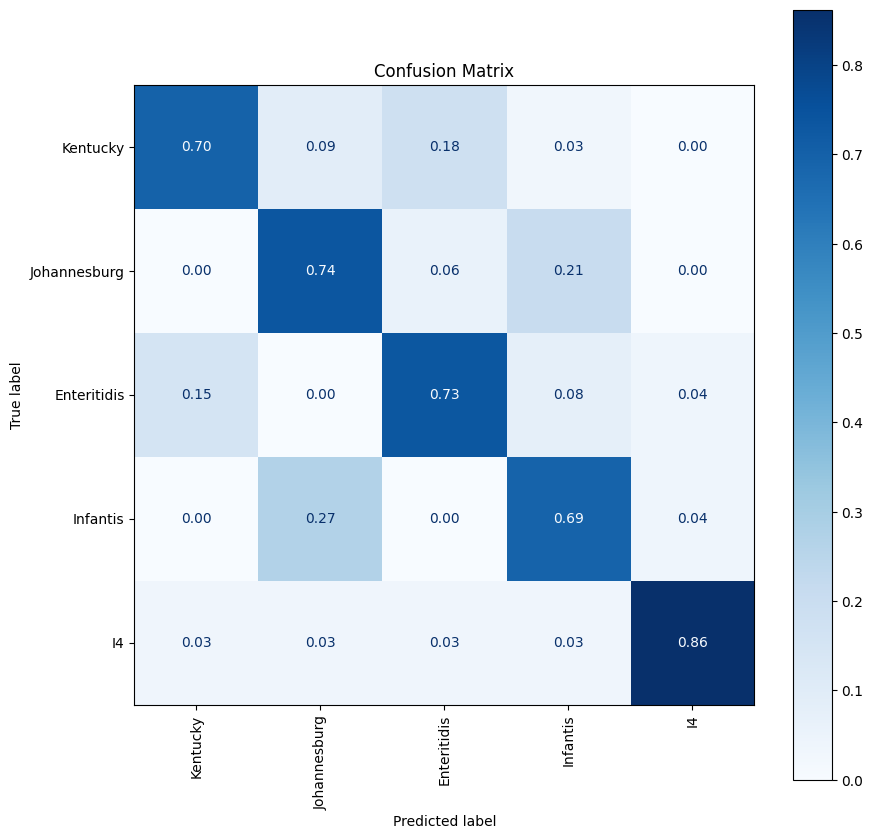

In [17]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
plt.title('Confusion Matrix')
plt.tight_layout
plt.xticks(rotation=90)
plt.show()